In [47]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io
import random
import scipy

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from utils import *
from eeg_feature_extraction.eeg_utils import *

%matplotlib inline

In [2]:
#duplicate_sents_data = pd.read_csv('./task_materials/duplicate_sentences.csv')
#duplicate_sents = list(duplicate_sents_data.sentence.values)

In [5]:
freq_domains = ['theta', 'alpha', 'beta']
feat_extraction_methods = ['RandomForest', 'NCA']
et_features = 'TRT'

In [10]:
with open('./transformed_eeg_features/transformed_eeg_features.json') as file:
    transformed_eeg_features_list = json.load(file)

In [13]:
transformed_eeg_features = {}
for feat_extract_method, (eeg_data, labels) in transformed_eeg_features_list.items():
    eeg_data = np.array(list(map(lambda word_vector: np.array(word_vector), eeg_data)))
    labels = np.array(list(map(lambda label: int(label), labels)))
    transformed_eeg_features[feat_extract_method] = (eeg_data, labels)

In [16]:
transformed_eeg_features_per_method = []
for i, (feat_extract_method, (eeg_data, labels)) in enumerate(transformed_eeg_features.items()):
    transformed_eeg_features_per_method.append(np.c_[dimensionality_reduction(eeg_data, labels.ravel(), feat_extract_method, k=2), labels])
    print('Transformation {} done!'.format(i+1))

Transformation 1 done!
Transformation 2 done!


In [55]:
accs = []
for i, X in enumerate(transformed_eeg_features_per_method):
    for i in range(X.shape[1]):
        if i < 2:
            # center and normalize data prior to classification or data visualisation
            mean, std = X[:, i].mean(), X[:, i].std()
            X[:, i] -= mean
            X[:, i] /= std
            assert int(X[:, i].mean()) == 0
    X, y = shuffle(X[:, :2], X[:, 2], random_state=rnd_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=rnd_state)
    y_train, y_test = y_train.ravel(), y_test.ravel()
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    acc = knn.score(X_test, y_test)
    accs.append(acc)
print(accs)

[0.7918045304148639, 0.9753117841689998]


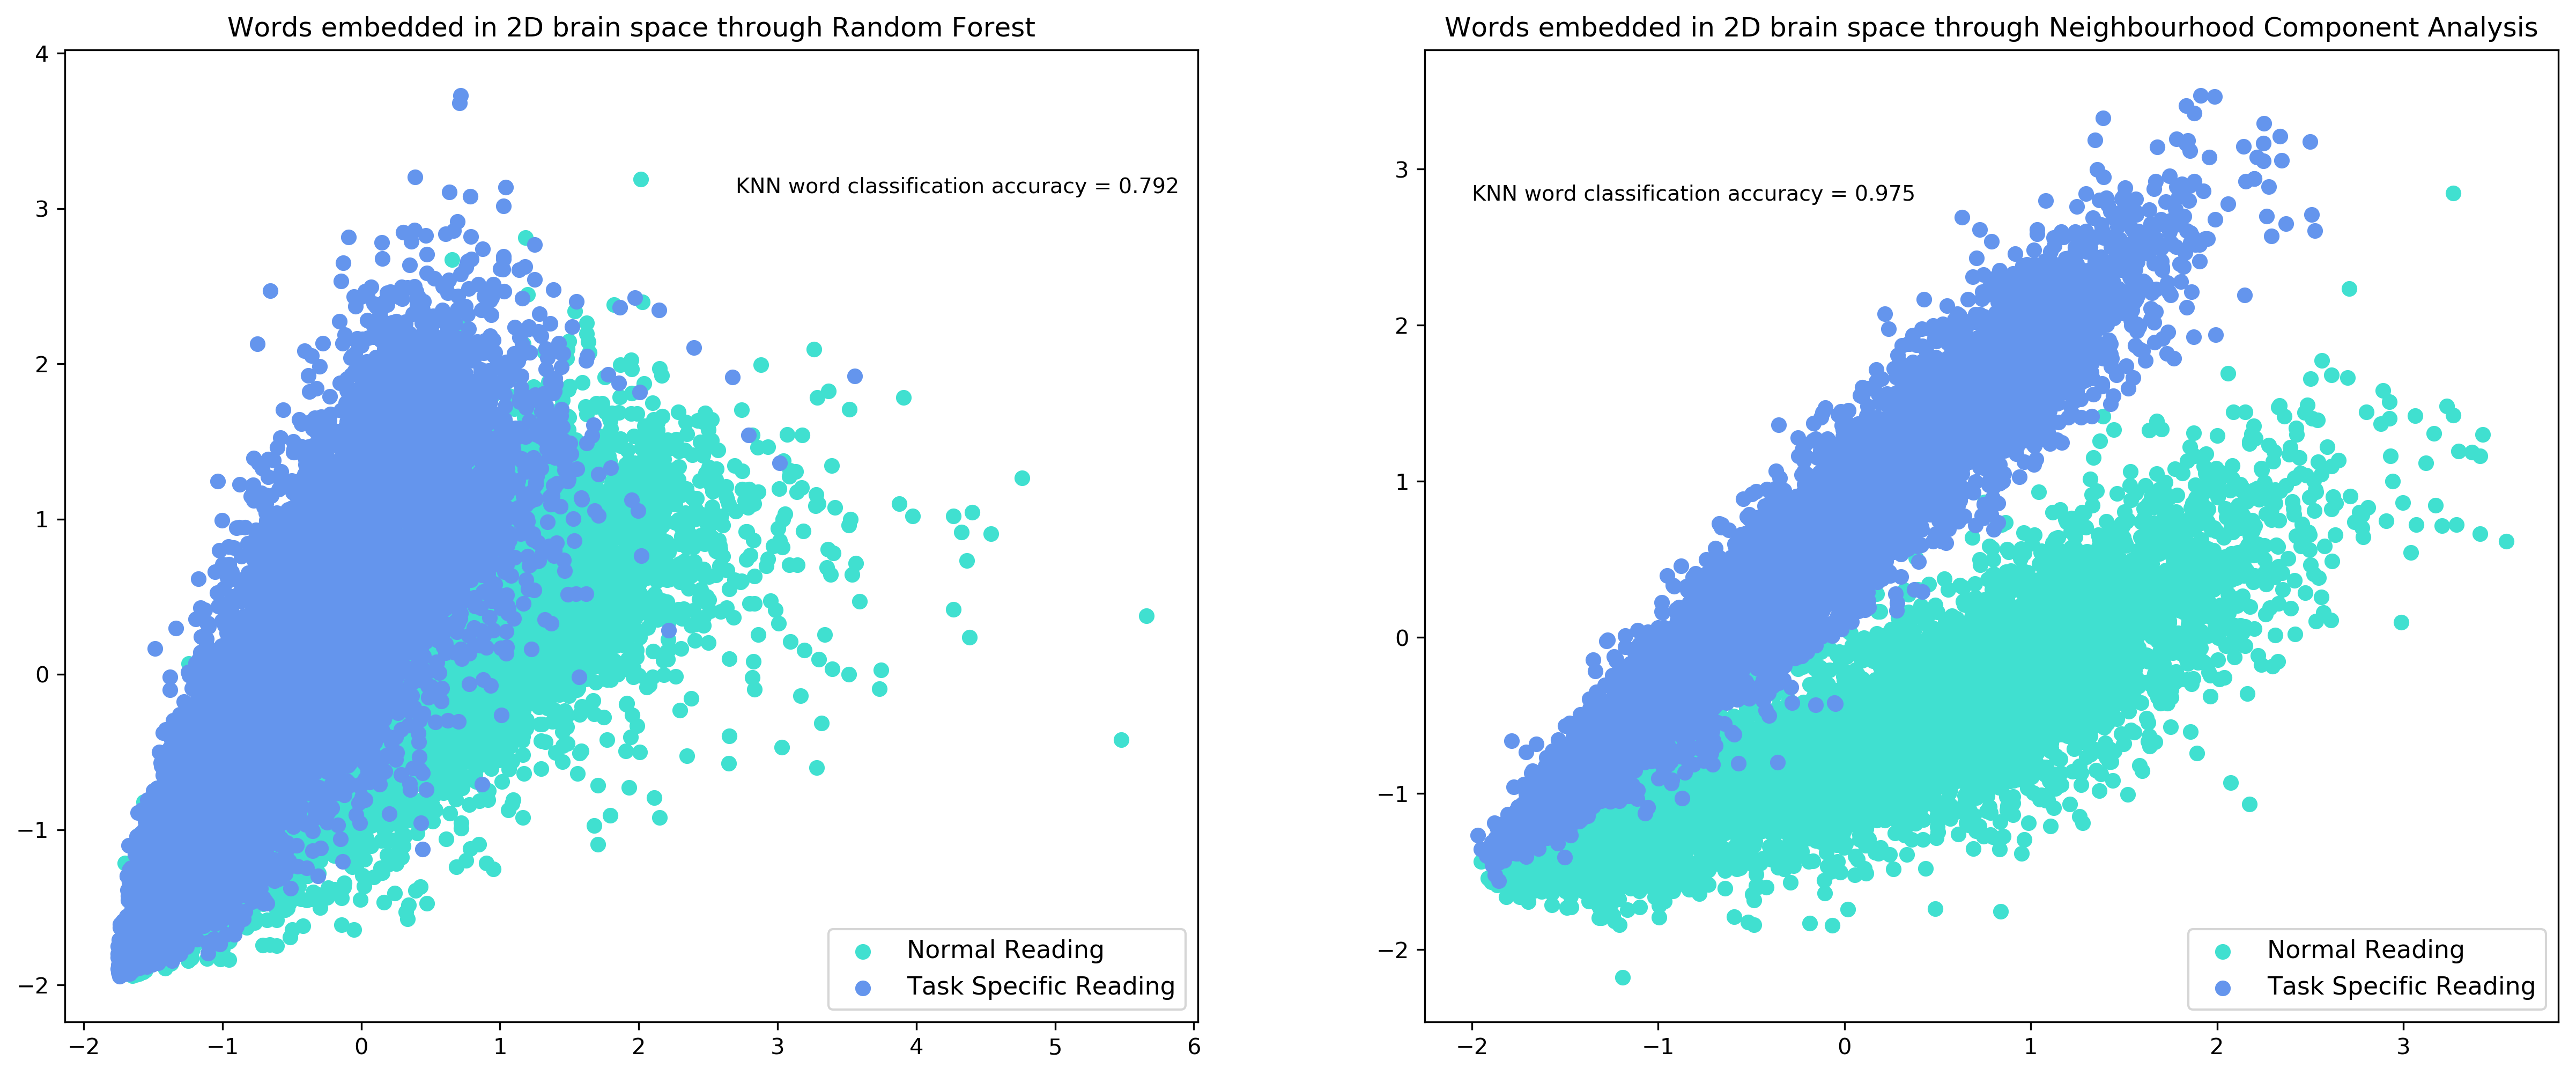

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=300)
names = ['Random Forest', 'Neighbourhood Component Analysis']
for i, (name, data, acc) in enumerate(zip(names, transformed_data, accs)):
    # Plot the projected points and show the evaluation score
    axes[i].scatter(data[data[:, 2] == 0][:,0], data[data[:, 2] == 0][:, 1], color = 'turquoise', label='Normal Reading')
    axes[i].scatter(data[data[:, 2] == 1][:,0], data[data[:, 2] == 1][:, 1], color = 'cornflowerblue', label='Task Specific Reading')
    axes[i].set_title("Words embedded in 2D brain space through {}".format(name))
    axes[i].legend(fancybox=True, framealpha=0.8, loc='lower right', prop={'size':11})
    xy_pos = (-2.0, 2.8) if i == 1 else (2.7, 3.1)
    axes[i].annotate('KNN word classification accuracy = {}'.format(round(acc, 3)), xy_pos, fontsize=9.5)

In [6]:
merge = 'avg' 
n_features = 'all'
evaluate=False
k = 15
et_feature = 'TRT'
rnd_state = 42
held_out_sents_task2, held_out_sents_task3 = get_held_out_sents('task2'), get_held_out_sents('task3')

for freq_domain in freq_domains:
    mean_eeg_feats_per_word_task2 = eeg_freqs_across_sbj('task2', freq_domain, merge, et_feature, n_features,
                                                      held_out_indices=held_out_sents_task2, all_sbjs=False,
                                                      dim_reduction=True)
    mean_eeg_feats_per_word_task3 = eeg_freqs_across_sbj('task3', freq_domain, merge, et_feature, n_features,
                                                          held_out_indices=held_out_sents_task3, all_sbjs=False,
                                                          dim_reduction=True)
    X_NR = remove_non_fixated_words(mean_eeg_feats_per_word_task2)
    X_AR = remove_non_fixated_words(mean_eeg_feats_per_word_task3)
    Y_NR = np.zeros((X_NR.shape[0], 1))
    Y_AR = np.ones((X_AR.shape[0], 1))
    X, y = np.vstack((X_NR, X_AR)), np.vstack((Y_NR, Y_AR))
    X, y = shuffle(X, y, random_state=rnd_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=rnd_state)
    y_train, y_test = y_train.ravel(), y_test.ravel()
    clf = RandomForestClassifier(n_estimators=100, criterion='gini', bootstrap=False, random_state=rnd_state)
    clf.fit(X_train, y_train)
    most_important_feats = clf.feature_importances_
    np.savetxt('eeg_feature_extraction/eeg_features_for_embeddings/' + freq_domain + '_' + et_feature + '.txt', np.argsort(most_important_feats)[::-1][:k])
    print("{} features extracted".format(freq_domain))

theta features extracted
alpha features extracted
beta features extracted


In [67]:
all_embeddings = compute_embeddings(feat_extraction_methods, freq_domains)

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
np.savetxt('embeddings/' + 'RandomForest' + '_' + 'NR' + '.txt', all_embeddings['RandomForest']['NR'])
np.savetxt('embeddings/' + 'RandomForest' + '_' + 'TSR' + '.txt', all_embeddings['RandomForest']['TSR'])
np.savetxt('embeddings/' + 'NCA' + '_' + 'NR' + '.txt', all_embeddings['NCA']['NR'])
np.savetxt('embeddings/' + 'NCA' + '_' + 'TSR' + '.txt', all_embeddings['NCA']['TSR'])